# Прогнозирование стоимости акций

## Импорт необходимых библиотек

In [213]:
!pip install pandas -q
!pip install sktime -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install sktime prophet -q
!pip install lightgbm -q
!pip install pmdarima -q

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

# Установка фиксированного значения
np.random.seed(42)

In [215]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from tqdm import TqdmWarning

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore', category=TqdmWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)

In [216]:
try:
    import sktime
    
except:
    #!pip install sktime --user
    #!pip install pmdarima
    #!pip install statsmodels
    #!pip install prophet
    !pip install --upgrade sktime[all_extras]
import sktime

In [217]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [218]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.compose import EnsembleForecaster
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.fbprophet import Prophet
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pearsonr

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)
r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

##

## Загрузка данных

Датасет содержит ежедневные исторические данные по акциям ПАО «Сбербанк» с 1 июня 1999 года, включая значения открытия, максимума, минимума, закрытия и объёма торгов. Датасет доступен по адресу: https://www.kaggle.com/datasets/olegshpagin/russia-stocks-prices-ohlcv/data.

* datetime — дата и время торговой сессии (формат: ГГГГ-ММ-ДД);
* open — цена открытия акции в начале торгового дня;
* high — цена открытия акции в начале торгового дня;
* low — минимальная цена акции в течение торгового дня;
* close — цена закрытия акции в конце торгового дня;
* volume — объём торгов акциями за торговый день, количество проданных акций.

Датасет доступен для использования по лицензии «MIT».
Это означает, что можно свободно:
- Использовать данные в любых целях, включая коммерческие.
- Копировать и распространять датасет.
- Адаптировать и модифицировать данные.
- Объединять датасет с другими материалами.

Условия:
* В любых копиях или производных работах необходимо сохранить уведомление об авторских правах (copyright notice) и текст лицензии.

* Данные предоставляются «как есть» (as is), без каких-либо гарантий. Авторы не несут ответственности за возможные ошибки или последствия использования датасета.

Ниже приведен текст лицензии MIT.
В интернете оригинал лицензии размещен по адресу: https://www.mit.edu/~amini/LICENSE.md

## Released under MIT License

Copyright (c) 2013 Mark Otto.

Copyright (c) 2017 Andrew Fong.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [219]:
df = pd.read_csv('SBER_D1.csv', delimiter = ',')
df

,datetime,open,high,low,close,volume
0,1999-06-01,0.54,0.54,0.53,0.53,778
1,1999-06-02,0.53,0.53,0.49,0.50,1926
2,1999-06-03,0.49,0.54,0.49,0.53,3346
3,1999-06-04,0.54,0.55,0.53,0.55,4694
4,1999-06-07,0.55,0.57,0.55,0.56,3505
...,...,...,...,...,...,...
6288,2024-08-21,266.16,267.80,263.86,266.93,3708836
6289,2024-08-22,266.93,268.50,260.15,261.60,4783843
6290,2024-08-23,261.70,262.80,255.56,259.50,7669263
6291,2024-08-26,263.55,266.95,261.54,265.39,4974413


In [220]:
## Предобработка данных

Проверим наличие пропусков и дубликатов в данных.

In [221]:
df.isna().sum()

datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

Пропущенные значения не обнаружены.

In [222]:
df.duplicated().sum()

0

Дубликаты не обнаружены

## Формирование одномерного ряда значений целевой переменной и соответствующего числового признака.

В качестве целевой переменной исследования выбрана цена закрытия (closing price) обыкновенных акций ПАО «Сбербанк» (тикер: SBER, Московская биржа), фиксируемая на момент завершения торговой сессии. Данный показатель является ключевым индикатором рыночной стоимости актива и широко используется в финансовом анализе для прогнозирования динамики котировок. Временной интервал исследования охватывает период с 3 января 2022 года по 27 августа 2024 года.

In [223]:
df = df.set_index('datetime')

In [224]:
df.index = pd.to_datetime(df.index)

In [225]:
df_cut = df.loc['2022-01-01':]

In [226]:
y = df_cut['close']

In [227]:
y.head()

datetime
2022-01-03    305.47
2022-01-04    304.24
2022-01-05    287.01
2022-01-06    293.92
2022-01-10    291.69
Name: close, dtype: float64

In [228]:
x = df_cut['volume']

In [229]:
x.astype('category')

datetime
2022-01-03    5018350
2022-01-04    5327042
2022-01-05    7001763
2022-01-06    7938244
2022-01-10    6742867
               ...   
2024-08-21    3708836
2024-08-22    4783843
2024-08-23    7669263
2024-08-26    4974413
2024-08-27    3232464
Name: volume, Length: 654, dtype: category
Categories (654, int64): [597530, 965677, 1000662, 1070973, ..., 48406108, 82968188, 94602057, 108424182]

In [230]:
x.head()

datetime
2022-01-03    5018350
2022-01-04    5327042
2022-01-05    7001763
2022-01-06    7938244
2022-01-10    6742867
Name: volume, dtype: int64

In [231]:
x.shape

(654,)

In [232]:
x_lag = x.shift(1)

In [233]:
x_lag.head()

datetime
2022-01-03          NaN
2022-01-04    5018350.0
2022-01-05    5327042.0
2022-01-06    7001763.0
2022-01-10    7938244.0
Name: volume, dtype: float64

In [234]:
x_lag = x_lag.fillna(x.iloc[0])

In [235]:
x_lag.head()

datetime
2022-01-03    5018350.0
2022-01-04    5018350.0
2022-01-05    5327042.0
2022-01-06    7001763.0
2022-01-10    7938244.0
Name: volume, dtype: float64

In [236]:
x_lag.shape

(654,)

In [237]:
# Приведение временных рядов к дневной частоте и заполнение появившихся пропусков NaN последним известным значением
y = y.asfreq('D', method='ffill')
x = x.asfreq('D', method='ffill')
x_lag = x_lag.asfreq('D', method='ffill')

## Визуализация временного ряда


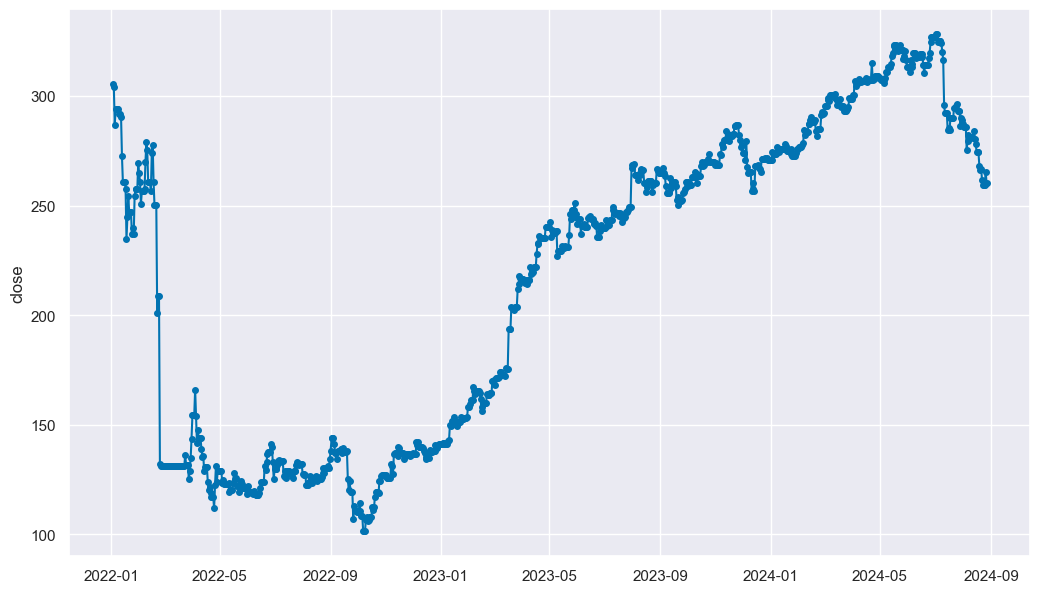

In [238]:
# Визуализация полученых данных при помощи встроенных утилит
fig, ax = plt.subplots(figsize=(12.4, 7.1)) 
sktime.utils.plotting.plot_series(y, ax=ax);

## Разбиение датасета на обучающую и тестовую выборки

Для разделения данных на обучающую и тестовую выборки воспользуемся функцией temporal_train_test_split. Она позволяет корректно разделить временной ряд, сохраняя хронологический порядок и не нарушая временные зависимости между наблюдениями.

Check splitted data size y: Train: 533, Test: 435


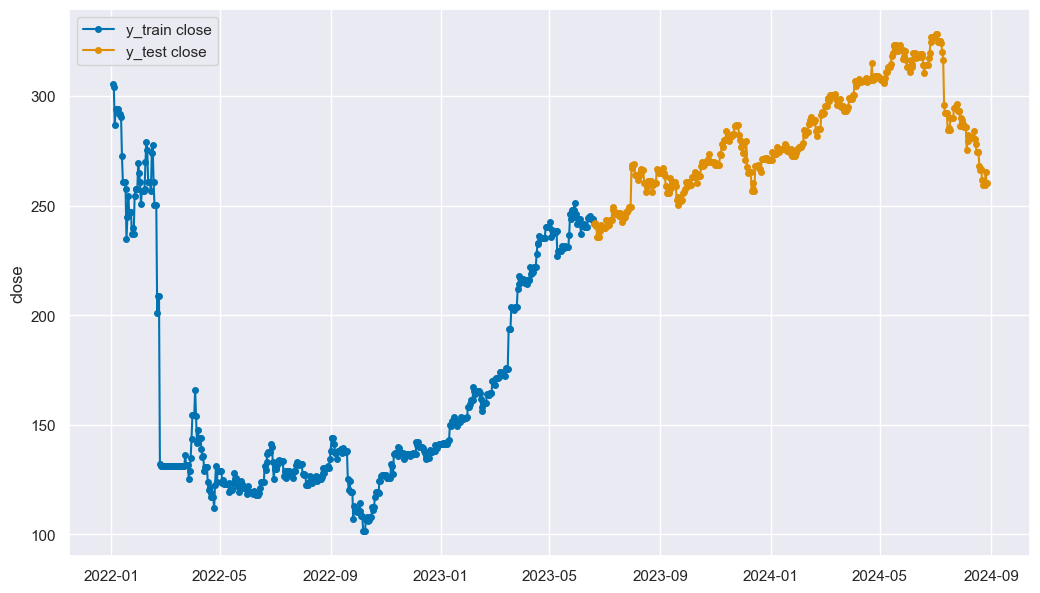

In [239]:
TEST_SIZE = int(0.45*y.size)

#y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)
y_train, y_test, x_train, x_test = temporal_train_test_split(y, x_lag, test_size=TEST_SIZE)
print(f'Check splitted data size y: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

fig, ax = plt.subplots(figsize=(12.4, 7.1)) 
sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train close", "y_test close"], ax=ax);

In [240]:
P_THRESHOLD = 0.05
def check_ADF(y_train, p_threshold = P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value<value else ""))    
    print(f'Result: The series is {"not " if p_value > p_threshold else ""}stationary')
    return result

check_ADF(y_train, p_threshold = P_THRESHOLD);

ADF Statistic: -1.3543
p-value: 0.6040
Critical Values:
	1%: -3.4372, 
	5%: -2.8646, 
	10%: -2.5684, 
Result: The series is not stationary


In [241]:
# Приведение временных рядов к дневной частоте и заполнение появившихся пропусков NaN последним известным значением
y_train = y_train.asfreq('D', method='ffill')
y_test = y_test.asfreq('D', method='ffill')
x_train = y_train.asfreq('D', method='ffill')
x_test = y_test.asfreq('D', method='ffill')

Помимо разделения данных на обучающую и тестовую выборки, для прогнозирования во фреймворке sktime необходимо явно задать так называемый горизонт прогнозирования (forecasting horizon) - то есть указать, на какие будущие моменты времени или на какое количество шагов вперёд нужно сделать предсказание. Для этого используется специальный объект класса «ForecastingHorizon» , с помощью которого можно гибко определить необходимые точки прогнозирования.

In [242]:
# ГОРИЗОНТ
#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False, freq='D')

In [243]:
# !!!Проверка частоты!!!
print(y.index.freq)
print(y_train.index.freq)
print(y_test.index.freq)
print(x.index.freq)
print(x_train.index.freq)
print(x_test.index.freq)
print(fh.freq)

<Day>
<Day>
<Day>
<Day>
<Day>
<Day>
D


In [244]:
# !!!Проверка проверка отсутствия NaN значений!!!
print(y.isna().sum())
print(y_train.isna().sum())
print(y_test.isna().sum())
print(x.isna().sum())
print(x_train.isna().sum())
print(x_test.isna().sum())

0
0
0
0
0
0


In [245]:
#y_std =(y_train-y_train.mean())/y_train.std()

In [246]:
#y_norm = (y_train - y_train.min()) / (y_train.max() - y_train.min())

In [247]:
y_train.shape

(533,)

# Прогнозирование стоимости акции ПАО «Сбербанк» с помощью моделей машинного обучения (без числовых признаков)

## Простое экспоненциальное сглаживание

sMAPE = 0.164
RMSE = 65.483


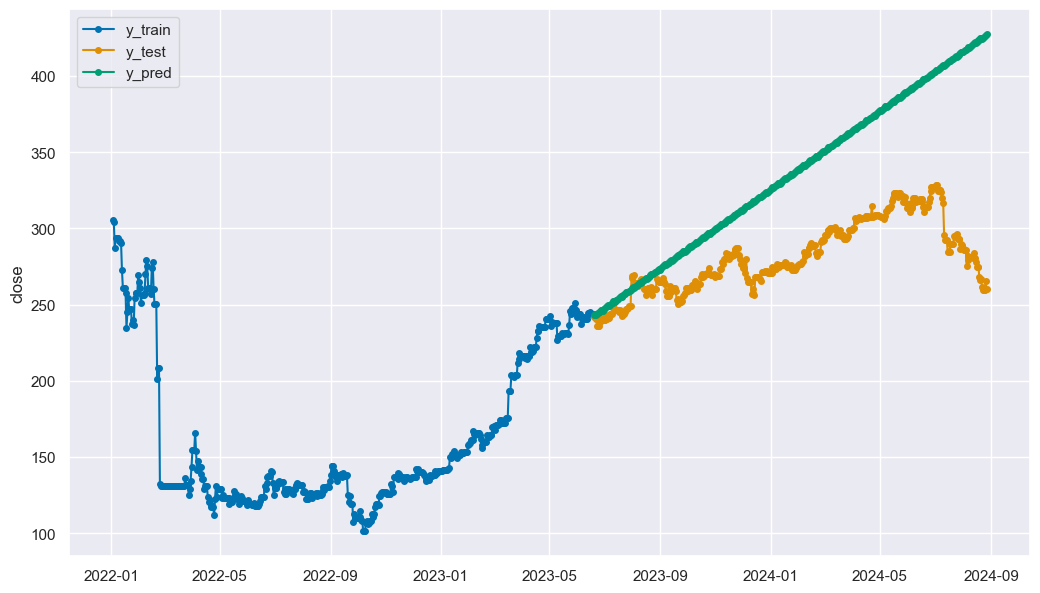

In [248]:
model1 = ExponentialSmoothing(trend='add', seasonal='add', sp=7)
model1.fit(y_train)
y_pred = model1.predict(fh)
fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Сложный метод экспоненциального сглаживания

sMAPE = 0.038
RMSE = 14.648


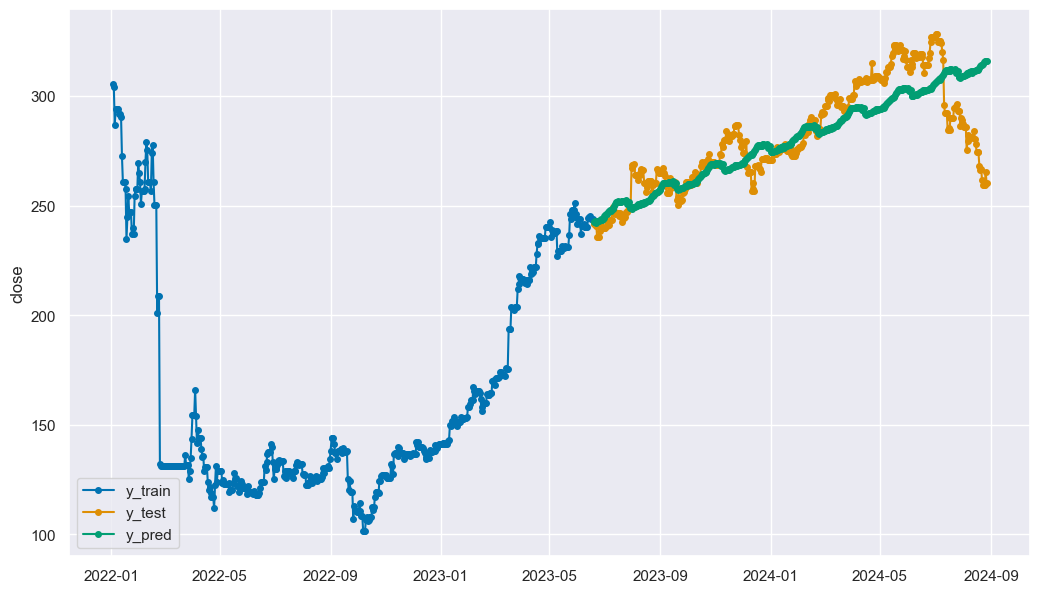

In [249]:
SEASON = 52  # 7 дней в неделе * 52 недели = 365 дней (год)

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

# ПРЕДСКАЗАТЕЛЬ
model2 = EnsembleForecaster([
    ("ses", ses),
    #("holt", holt),
    ("damped", damped_holt),
    ("holt-winter", holt_winter),
    #("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
    #("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
    #("holt-winter, multiplicative season, box-cox", holt_winter_sadd_boxcox),
    #("holt-winter, multiplicative both,   box-cox", holt_winter_smul_boxcox)
])
model2.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = model2.predict(fh)
fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Автоматизированный подбор параметров модели экспоненциального сглаживания

Автоматизированный подбор параметров модели экспоненциального сглаживания

sMAPE = 0.146
RMSE = 45.503


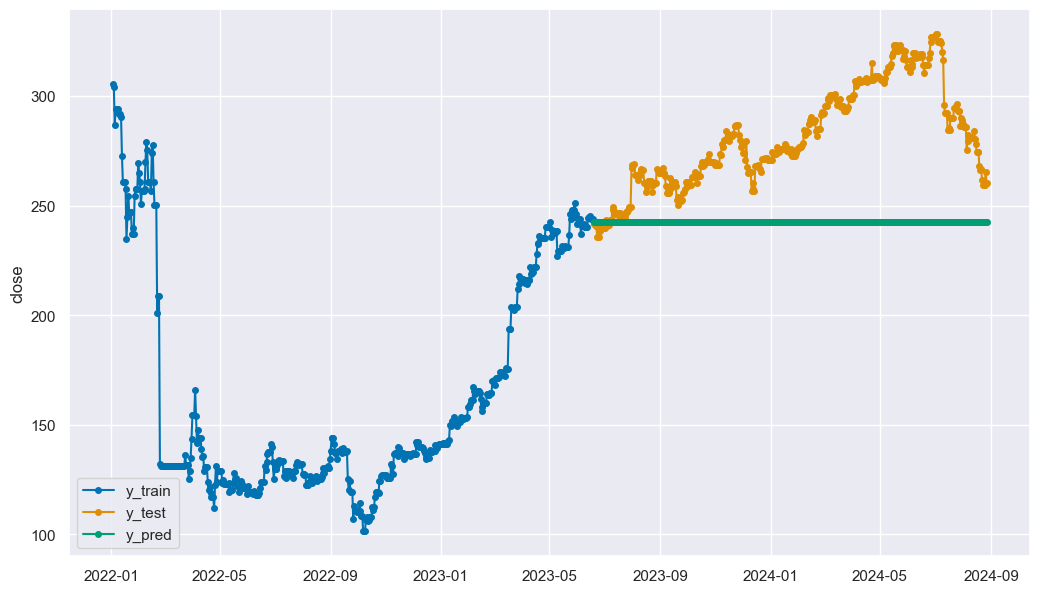

In [250]:
from sktime.forecasting.ets import AutoETS
model3 = AutoETS(auto=True, sp=SEASON, n_jobs=-1)
model3.fit(y_train)
y_pred = model3.predict(fh)
fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

In [251]:
## Регрессионная модель на основе алгоритма K-ближайших соседей (KNN Regression)

sMAPE = 0.155
RMSE = 47.378


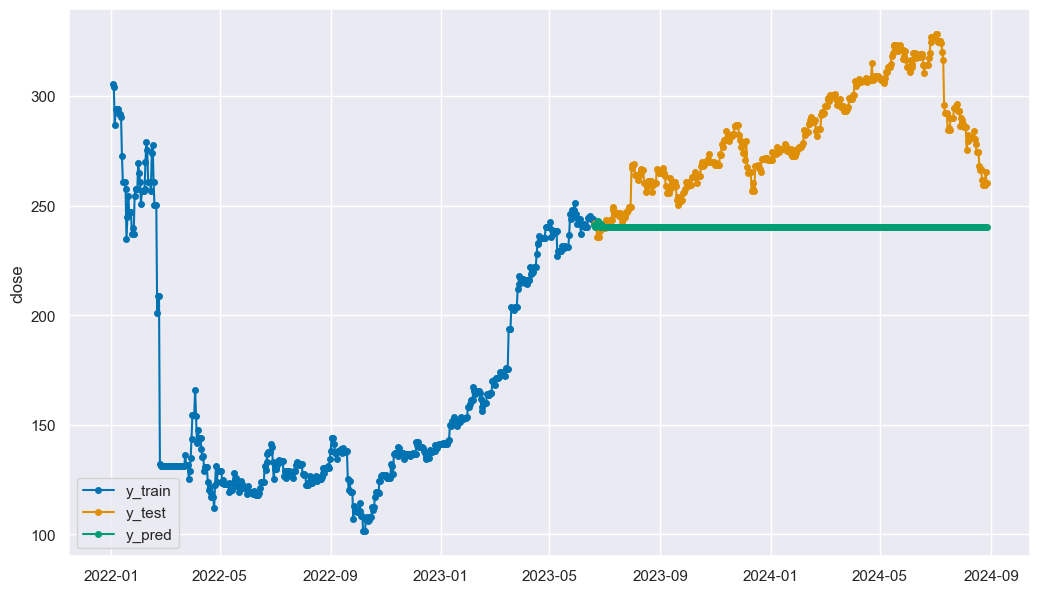

In [252]:
REGRESSION_WINDOW = 6
regressor  = KNeighborsRegressor(n_neighbors=3)
model4 = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")
model4.fit(y_train)
y_pred = model4.predict(fh)
fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Современный метод регресии Prophet представленный в пакете SKTime

09:22:12 - cmdstanpy - INFO - Chain [1] start processing
09:22:13 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.075
RMSE = 24.590


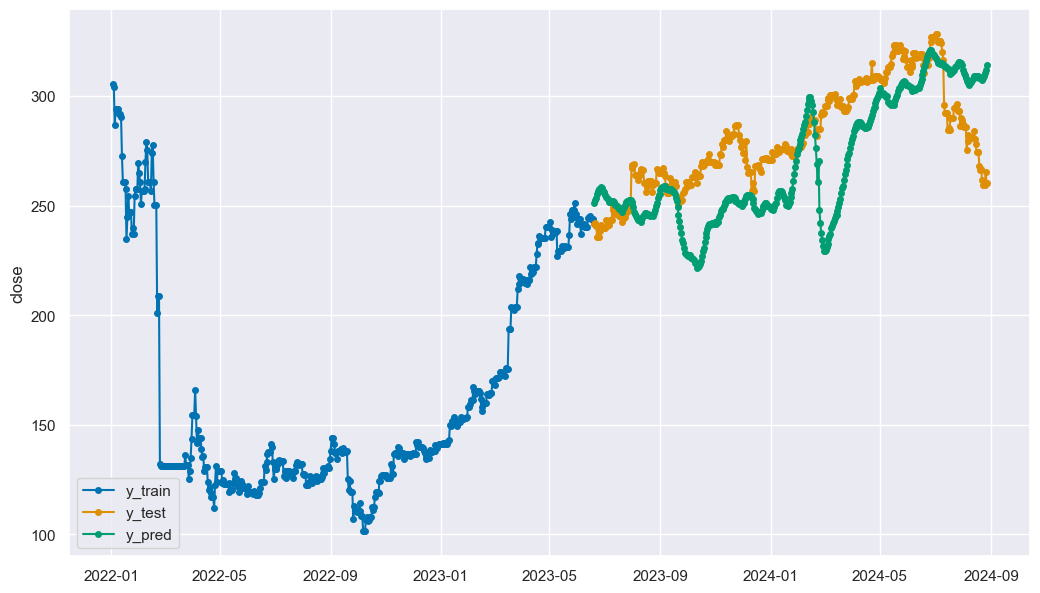

In [253]:
model5 = Prophet(
                    changepoint_prior_scale=0.56,
                    changepoint_range=0.80,
                    seasonality_mode='additive',
                    n_changepoints=21,
                    add_country_holidays={'country_name': 'Russia'},
                    yearly_seasonality=22,
                    growth='linear')

model5.set_random_state(42)
model5.fit(y_train)
y_pred = model5.predict(fh)
fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Регрессионная модель градиентного бустинга для временных рядов на базе библиотеки Sktime

sMAPE = 0.145
RMSE = 45.063


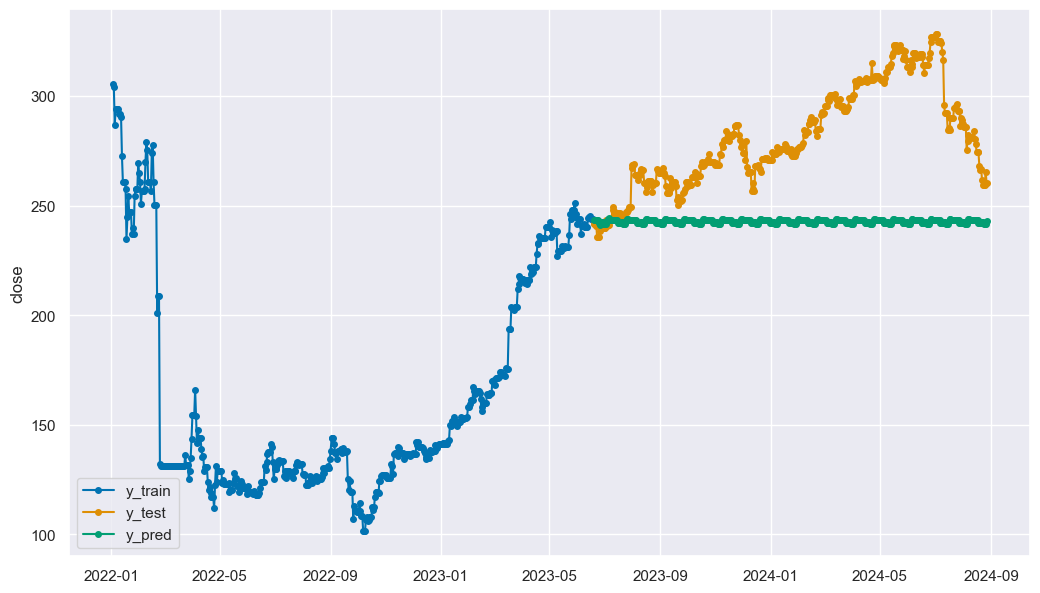

In [254]:
REGRESSION_WINDOW = 12

model6 = GradientBoostingRegressor(
                                     n_estimators=100,
                                     max_depth=3,
                                     learning_rate=0.1,
                                     random_state=42)

model6 = make_reduction(
                           regressor, 
                           window_length=REGRESSION_WINDOW, 
                           strategy="recursive")

model6.fit(y_train)

y_pred = model6.predict(fh)

fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Модель SARIMA с алгоритмом автоматизированного подбора оптимальных параметров

In [255]:
model7 = AutoARIMA(start_p=0,  # начальный порядок AR
                  d=None,     # Порядок производной
                  start_q=0,  # начальный порядок MA
                  max_p=6,    # конечный порядок AR
                  max_q=6,    # конечный порядок MA
                  seasonal=True,  # Использовать SARIMA
                  start_P=0,  # начальный порядок SAR
                  start_Q=0,  # начальный порядок SMA
                  D=None,     # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 10,  # Максимальный порядок p+q+P+Q
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',
                  suppress_warnings=True)

model7.fit(y_train)

model7.summary()

c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\d

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[52] intercept   : AIC=3708.215, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[52] intercept   : AIC=3577.869, Time=2.40 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,1)[52] intercept   : AIC=inf, Time=6.03 sec
 ARIMA(0,2,0)(0,0,0)[52]             : AIC=3706.215, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[52] intercept   : AIC=3575.873, Time=0.08 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(0,0,1)[52] intercept   : AIC=3577.868, Time=2.17 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,0,1)[52] intercept   : AIC=3579.873, Time=2.82 sec
 ARIMA(2,2,0)(0,0,0)[52] intercept   : AIC=3371.670, Time=0.08 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(1,0,0)[52] intercept   : AIC=3373.465, Time=2.29 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(0,0,1)[52] intercept   : AIC=3373.456, Time=3.17 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(1,0,1)[52] intercept   : AIC=3375.441, Time=6.64 sec
 ARIMA(3,2,0)(0,0,0)[52] intercept   : AIC=3347.294, Time=0.17 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(1,0,0)[52] intercept   : AIC=3349.040, Time=4.34 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(0,0,1)[52] intercept   : AIC=3349.019, Time=3.63 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(1,0,1)[52] intercept   : AIC=3350.958, Time=8.02 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,0)[52] intercept   : AIC=3338.248, Time=0.23 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,0)[52] intercept   : AIC=3339.876, Time=5.36 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,1)[52] intercept   : AIC=3339.849, Time=4.60 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,1)[52] intercept   : AIC=3341.795, Time=8.49 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,0)(0,0,0)[52] intercept   : AIC=3339.918, Time=0.27 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.84 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.62 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(4,2,0)(0,0,0)[52]             : AIC=3336.253, Time=0.14 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,0)[52]             : AIC=3337.880, Time=1.20 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,1)[52]             : AIC=3337.854, Time=1.87 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,1)[52]             : AIC=3339.800, Time=4.00 sec
 ARIMA(3,2,0)(0,0,0)[52]             : AIC=3345.299, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[52]             : AIC=3337.923, Time=0.11 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(0,0,0)[52]             : AIC=inf, Time=0.27 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(0,0,0)[52]             : AIC=3279.292, Time=0.21 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(1,0,0)[52]             : AIC=3280.443, Time=4.53 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(0,0,1)[52]             : AIC=3280.404, Time=4.23 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(1,0,1)[52]             : AIC=3282.387, Time=7.34 sec
 ARIMA(2,2,1)(0,0,0)[52]             : AIC=3323.273, Time=0.13 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,2)(0,0,0)[52]             : AIC=inf, Time=0.37 sec
 ARIMA(2,2,0)(0,0,0)[52]             : AIC=3369.674, Time=0.05 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,2)(0,0,0)[52]             : AIC=3305.056, Time=0.22 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,2)(0,0,0)[52]             : AIC=3283.273, Time=0.27 sec

Best model:  ARIMA(3,2,1)(0,0,0)[52]          
Total fit time: 88.351 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  533
Model:               SARIMAX(3, 2, 1)   Log Likelihood               -1634.646
Date:                Fri, 30 May 2025   AIC                           3279.292
Time:                        09:23:42   BIC                           3300.666
Sample:                    01-03-2022   HQIC                          3287.657
                         - 06-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0139      0.039     -0.358      0.720      -0.090       0.062
ar.L2         -0.0915      0.046     -1.988      0.047      -0.182      -0.001
ar.L3          0.2955      0.013     22.631      0.000       0.270       0.321
ma.L1         -0.9896      0.015    -67.018      0.000      -1.019      -0.961
sigma2        27.4365      0.599     45.841      0.000      26.263      28.610
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):             42470.89
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -3.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


sMAPE = 0.152
RMSE = 60.511


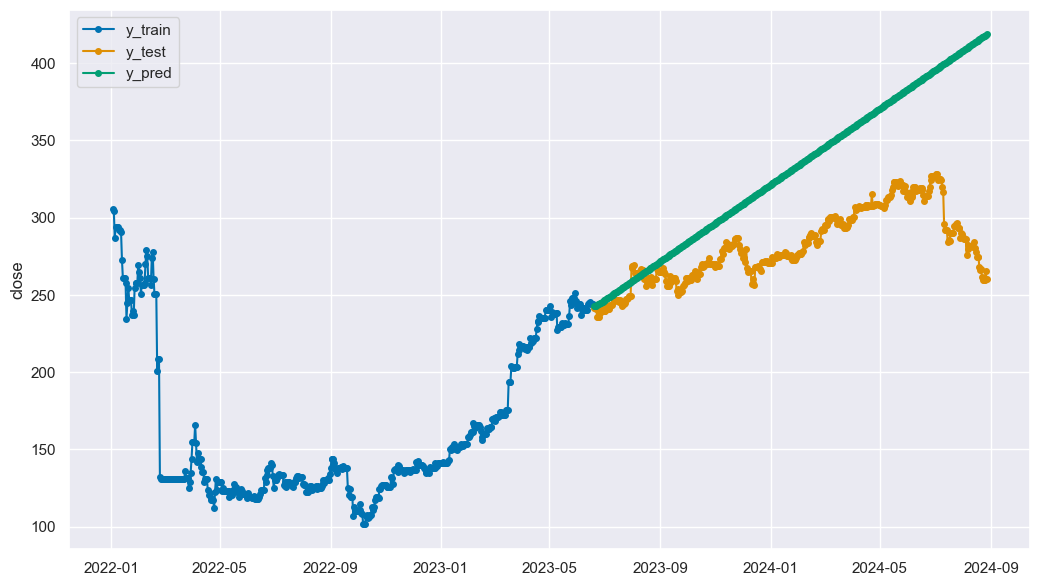

In [256]:
y_pred = model7.predict(fh)
fig, ax = plt.subplots(figsize=(12.4, 7))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Ансамблевая модель машинного обучения на основе объединения прогнозов нескольких алгоритмов

c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\d

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[52] intercept   : AIC=3708.215, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[52] intercept   : AIC=3577.869, Time=2.39 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,1)[52] intercept   : AIC=inf, Time=6.08 sec
 ARIMA(0,2,0)(0,0,0)[52]             : AIC=3706.215, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[52] intercept   : AIC=3575.873, Time=0.08 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(0,0,1)[52] intercept   : AIC=3577.868, Time=2.30 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,0,1)[52] intercept   : AIC=3579.873, Time=2.90 sec
 ARIMA(2,2,0)(0,0,0)[52] intercept   : AIC=3371.670, Time=0.08 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(1,0,0)[52] intercept   : AIC=3373.465, Time=2.33 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(0,0,1)[52] intercept   : AIC=3373.456, Time=3.18 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(1,0,1)[52] intercept   : AIC=3375.441, Time=6.53 sec
 ARIMA(3,2,0)(0,0,0)[52] intercept   : AIC=3347.294, Time=0.16 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(1,0,0)[52] intercept   : AIC=3349.040, Time=4.15 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(0,0,1)[52] intercept   : AIC=3349.019, Time=3.59 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(1,0,1)[52] intercept   : AIC=3350.958, Time=8.06 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,0)[52] intercept   : AIC=3338.248, Time=0.23 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,0)[52] intercept   : AIC=3339.876, Time=5.41 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,1)[52] intercept   : AIC=3339.849, Time=4.91 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,1)[52] intercept   : AIC=3341.795, Time=8.39 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,0)(0,0,0)[52] intercept   : AIC=3339.918, Time=0.26 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.79 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.62 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(4,2,0)(0,0,0)[52]             : AIC=3336.253, Time=0.09 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,0)[52]             : AIC=3337.880, Time=1.11 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,1)[52]             : AIC=3337.854, Time=2.03 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,1)[52]             : AIC=3339.800, Time=4.09 sec
 ARIMA(3,2,0)(0,0,0)[52]             : AIC=3345.299, Time=0.08 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,0)(0,0,0)[52]             : AIC=3337.923, Time=0.16 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(0,0,0)[52]             : AIC=inf, Time=0.36 sec
 ARIMA(3,2,1)(0,0,0)[52]             : AIC=3279.292, Time=0.20 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(1,0,0)[52]             : AIC=3280.443, Time=4.35 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(0,0,1)[52]             : AIC=3280.404, Time=4.17 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(1,0,1)[52]             : AIC=3282.387, Time=7.47 sec
 ARIMA(2,2,1)(0,0,0)[52]             : AIC=3323.273, Time=0.10 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,2)(0,0,0)[52]             : AIC=inf, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[52]             : AIC=3369.674, Time=0.05 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,2)(0,0,0)[52]             : AIC=3305.056, Time=0.26 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,2)(0,0,0)[52]             : AIC=3283.273, Time=0.27 sec

Best model:  ARIMA(3,2,1)(0,0,0)[52]          
Total fit time: 88.610 seconds


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


sMAPE = 0.035
RMSE = 15.538


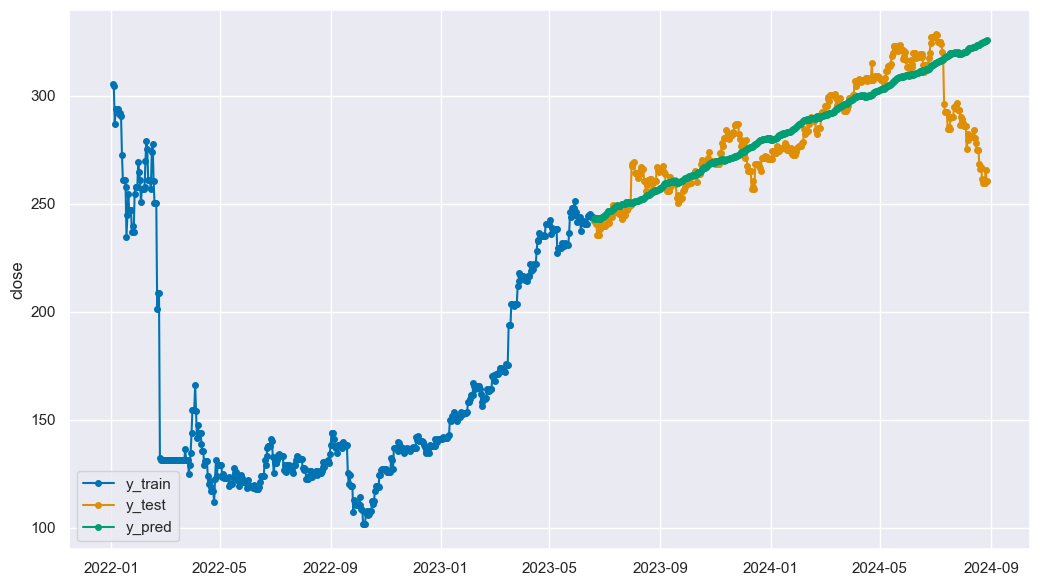

In [257]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
#   ("SES", model1),
    ("ETS", model2),
#    ("AutoETS", model3),
#   ("KNN", model4),
#   ("Prophet", model5),    
    ("GB", model6),
    ("Sarima", model7),
])
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
fig, ax = plt.subplots(figsize=(12.4, 7))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

# Прогнозирование стоимости акции ПАО «Сбербанк» с помощью моделей машинного обучения (с числовым признаком - "торговый объем").


In [258]:
# Вычисление коэффициента корреляции Пирсона и p-value
correlation_coefficient, p_value = pearsonr(x, y)

print("Коэффициент корреляции:", correlation_coefficient)
print("p-value:", p_value)

Коэффициент корреляции: -0.17476424041345265
p-value: 4.4365603622754476e-08


In [259]:
## Регрессионная модель на основе алгоритма K-ближайших соседей (KNN Regression) с обработкой числового признака

sMAPE = 0.052
RMSE = 17.921


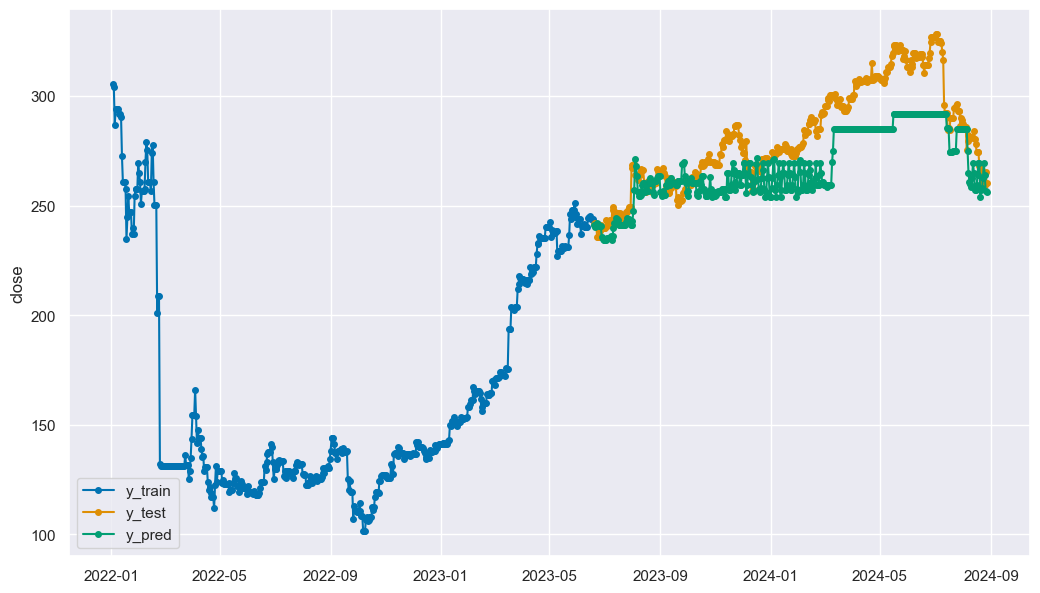

In [260]:
REGRESSION_WINDOW = 6
regressor  = KNeighborsRegressor(n_neighbors=3)
model8 = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")
model8.fit(y_train, X=x_train)
y_pred = model8.predict(fh, X=x_test)
fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Регрессионная модель градиентного бустинга для временных рядов с обработкой числового признака на базе библиотеки Sktime

sMAPE = 0.057
RMSE = 18.885


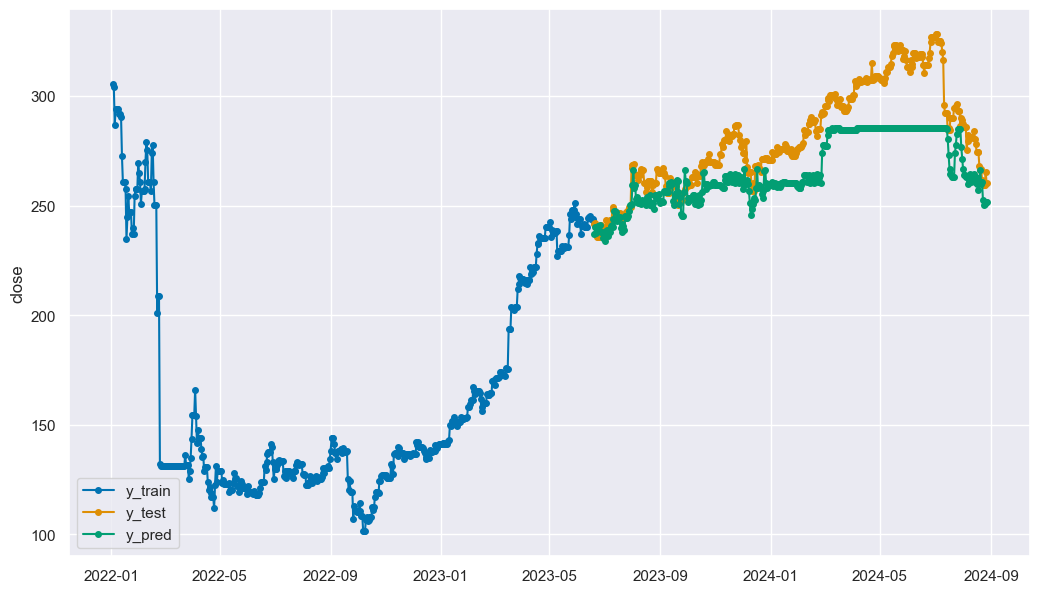

In [261]:
regressor = GradientBoostingRegressor(
                                     n_estimators=100,
                                     max_depth=13,
                                     learning_rate=0.11,
                                     random_state=42)

model9 = make_reduction(
                           regressor, 
                           window_length=REGRESSION_WINDOW, 
                           strategy="recursive")

model9.fit(y_train, X=x_train)
y_pred = model9.predict(fh, X=x_test)
fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Ансамблевая модель машинного обучения на основе объединения прогнозов нескольких алгоритмов

c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\d

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[52] intercept   : AIC=3708.215, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[52] intercept   : AIC=3577.869, Time=2.39 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(0,2,0)(0,0,0)[52]             : AIC=3706.215, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[52] intercept   : AIC=3575.873, Time=0.09 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(0,0,1)[52] intercept   : AIC=3577.868, Time=2.41 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,0,1)[52] intercept   : AIC=3579.873, Time=2.90 sec
 ARIMA(2,2,0)(0,0,0)[52] intercept   : AIC=3371.670, Time=0.08 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(1,0,0)[52] intercept   : AIC=3373.465, Time=2.35 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(0,0,1)[52] intercept   : AIC=3373.456, Time=3.17 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(1,0,1)[52] intercept   : AIC=3375.441, Time=6.61 sec
 ARIMA(3,2,0)(0,0,0)[52] intercept   : AIC=3347.294, Time=0.15 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(1,0,0)[52] intercept   : AIC=3349.040, Time=3.98 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(0,0,1)[52] intercept   : AIC=3349.019, Time=3.66 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(1,0,1)[52] intercept   : AIC=3350.958, Time=8.31 sec
 ARIMA(4,2,0)(0,0,0)[52] intercept   : AIC=3338.248, Time=0.20 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,0)[52] intercept   : AIC=3339.876, Time=5.67 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,1)[52] intercept   : AIC=3339.849, Time=4.86 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,1)[52] intercept   : AIC=3341.795, Time=8.67 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,0)(0,0,0)[52] intercept   : AIC=3339.918, Time=0.26 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.91 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.59 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,2,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(4,2,0)(0,0,0)[52]             : AIC=3336.253, Time=0.09 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,0)[52]             : AIC=3337.880, Time=1.15 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(0,0,1)[52]             : AIC=3337.854, Time=1.80 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(1,0,1)[52]             : AIC=3339.800, Time=4.26 sec
 ARIMA(3,2,0)(0,0,0)[52]             : AIC=3345.299, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[52]             : AIC=3337.923, Time=0.11 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(0,0,0)[52]             : AIC=inf, Time=0.25 sec
 ARIMA(3,2,1)(0,0,0)[52]             : AIC=3279.292, Time=0.19 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(1,0,0)[52]             : AIC=3280.443, Time=4.35 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(0,0,1)[52]             : AIC=3280.404, Time=4.15 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(1,0,1)[52]             : AIC=3282.387, Time=7.28 sec
 ARIMA(2,2,1)(0,0,0)[52]             : AIC=3323.273, Time=0.07 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,2)(0,0,0)[52]             : AIC=inf, Time=0.30 sec
 ARIMA(2,2,0)(0,0,0)[52]             : AIC=3369.674, Time=0.08 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,2)(0,0,0)[52]             : AIC=3305.056, Time=0.28 sec


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,2)(0,0,0)[52]             : AIC=3283.273, Time=0.26 sec

Best model:  ARIMA(3,2,1)(0,0,0)[52]          
Total fit time: 88.959 seconds


c:\Users\teleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


sMAPE = 0.035
RMSE = 15.469


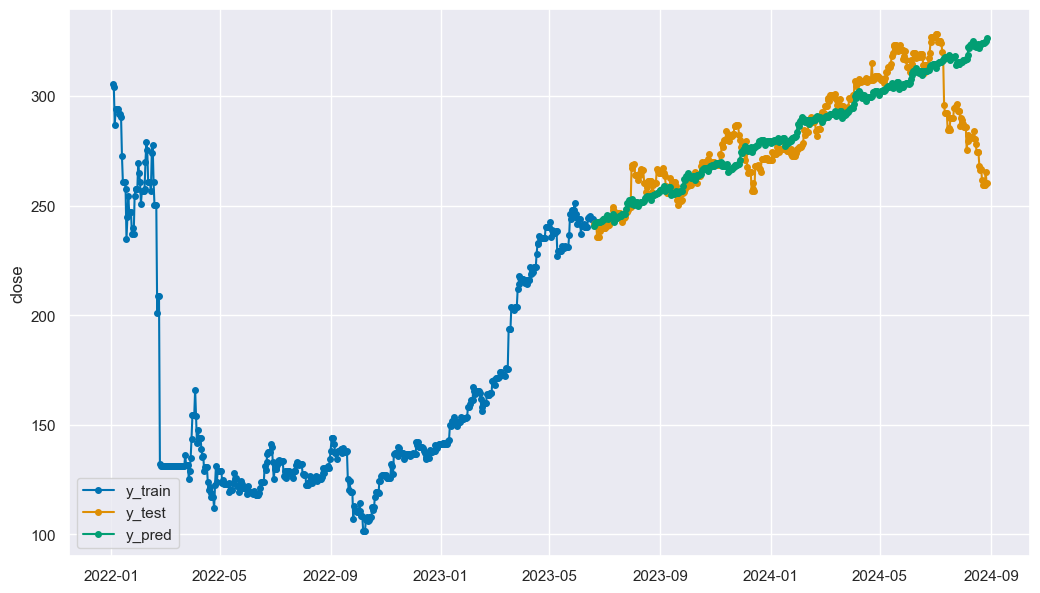

In [262]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
#   ("SES", model1),
    ("ETS", model2),
#    ("AutoETS", model3),
#   ("KNN-num", model8),
#   ("Prophet", model5),    
    ("GB-num", model9),
    ("Sarima", model7),
])
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
fig, ax = plt.subplots(figsize=(12.4, 7.1))
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], ax=ax)

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'RMSE = {rmse(y_pred.values, y_test.values):.3f}')

## Сравнение распределения ошибок sMAPE моделей прогнозирования: KNN, KNN-num и GBR, GBR-num

In [263]:
y_pred4 = model4.predict(fh)
y_pred8 = model8.predict(fh, X=x_test)
y_pred6 = model6.predict(fh)
y_pred9 = model9.predict(fh, X=x_test)


C:\Users\teleg\AppData\Local\Temp\ipykernel_2636\3383280622.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([smape_knn, smape_knn_num, smape_gbr, smape_gbr_num], labels=['KNN', 'KNN-num', 'GBR','GBR-num'])


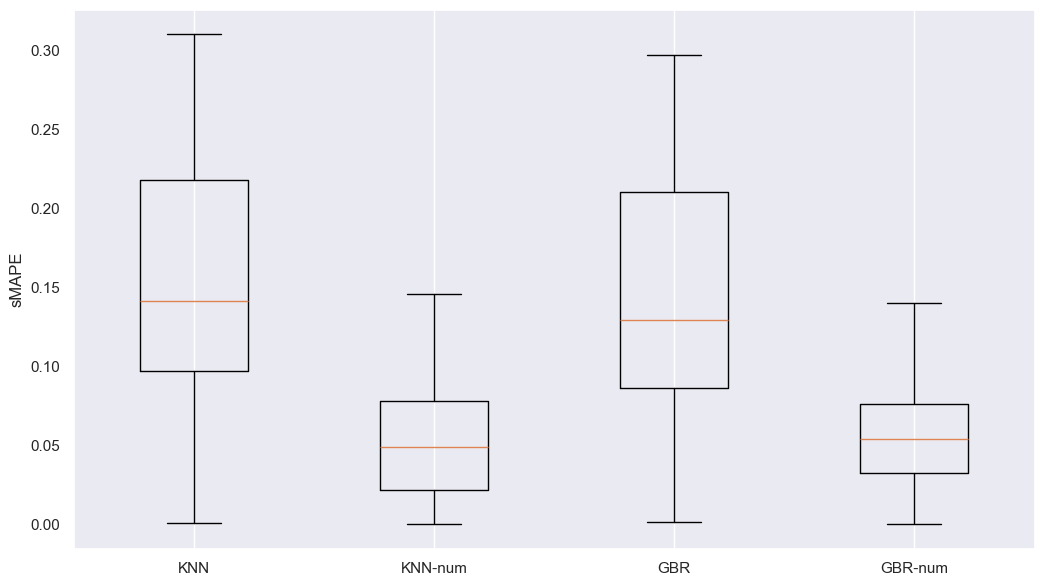

In [264]:
# Boxplot

# y_pred4, y_pred8, y_test — это pandas.Series, преобразуем их в массивы
y_pred4_arr = np.array(y_pred4)
y_pred8_arr = np.array(y_pred8)
y_pred6_arr = np.array(y_pred6)
y_pred9_arr = np.array(y_pred9)
y_test_arr = np.array(y_test)

# Функция для поэлементного sMAPE
def smape_vec(y_pred, y_true):
    return 2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)

# Вычисляем sMAPE для каждой модели
smape_knn = smape_vec(y_pred4_arr, y_test_arr)
smape_knn_num = smape_vec(y_pred8_arr, y_test_arr)
smape_gbr = smape_vec(y_pred6_arr, y_test_arr)
smape_gbr_num = smape_vec(y_pred9_arr, y_test_arr)


# Строим boxplot
plt.figure(figsize=(12.4, 7))
plt.boxplot([smape_knn, smape_knn_num, smape_gbr, smape_gbr_num], labels=['KNN', 'KNN-num', 'GBR','GBR-num'])
plt.ylabel('sMAPE')
# plt.title('Сравнение распределения ошибок sMAPE моделей прогнозирования: KNN, KNN-num и GBR, GBR-num')
plt.grid(axis='y')
plt.show()

Расчёт 95% доверительных интервалов для средних значений sMAPE моделей KNN, KNN-num, GBR и GBR-num

In [265]:
n_iterations = 1000
results = {}

model_names = ['KNN', 'KNN-num', 'GBR', 'GBR-num']
smape_errors = [smape_knn, smape_knn_num, smape_gbr, smape_gbr_num]
# Для RMSE: это массивы абсолютных ошибок для каждой точки
rmse_errors = [
    np.abs(y_pred4_arr - y_test_arr),
    np.abs(y_pred8_arr - y_test_arr),
    np.abs(y_pred6_arr - y_test_arr),
    np.abs(y_pred9_arr - y_test_arr)
]

for name, smape_arr, rmse_arr in zip(model_names, smape_errors, rmse_errors):
    # sMAPE
    smape_means = []
    n = len(smape_arr)
    for _ in range(n_iterations):
        sample = np.random.choice(smape_arr, size=n, replace=True)
        smape_means.append(np.mean(sample))
    smape_means = np.array(smape_means)
    smape_ci_lower = np.percentile(smape_means, 2.5)
    smape_ci_upper = np.percentile(smape_means, 97.5)
    smape_mean_val = np.mean(smape_means)

    # RMSE
    rmse_means = []
    for _ in range(n_iterations):
        sample = np.random.choice(rmse_arr, size=n, replace=True)
        rmse_means.append(np.sqrt(np.mean(sample ** 2)))
    rmse_means = np.array(rmse_means)
    rmse_ci_lower = np.percentile(rmse_means, 2.5)
    rmse_ci_upper = np.percentile(rmse_means, 97.5)
    rmse_mean_val = np.mean(rmse_means)

    results[name] = {
        'sMAPE': (smape_mean_val, smape_ci_lower, smape_ci_upper),
        'RMSE': (rmse_mean_val, rmse_ci_lower, rmse_ci_upper)
    }

# Выводим результаты
for name in results:
    s_mean, s_lo, s_hi = results[name]['sMAPE']
    r_mean, r_lo, r_hi = results[name]['RMSE']
    print(f"{name}:")
    print(f"  средний sMAPE = {s_mean:.3f} (95% ДИ: {s_lo:.3f} – {s_hi:.3f})")
    print(f"  средний RMSE  = {r_mean:.3f} (95% ДИ: {r_lo:.3f} – {r_hi:.3f})\n")

KNN:
  средний sMAPE = 0.155 (95% ДИ: 0.147 – 0.163)
  средний RMSE  = 47.390 (95% ДИ: 45.270 – 49.451)

KNN-num:
  средний sMAPE = 0.052 (95% ДИ: 0.049 – 0.055)
  средний RMSE  = 17.914 (95% ДИ: 16.962 – 18.805)

GBR:
  средний sMAPE = 0.145 (95% ДИ: 0.137 – 0.152)
  средний RMSE  = 45.048 (95% ДИ: 43.012 – 47.174)

GBR-num:
  средний sMAPE = 0.057 (95% ДИ: 0.054 – 0.060)
  средний RMSE  = 18.906 (95% ДИ: 17.841 – 19.920)

